In [1]:
import os
os.chdir('/nfs/home/vaschetti/maxarSrc/')

In [2]:
import argparse
import torch

from maxarseg.assemble import names
from maxarseg.assemble import holders
from maxarseg.configs import Config
from maxarseg.samplers import samplers_utils

In [3]:
from maxarseg.configs import Config
import yaml
cfg = Config('./configs/custom_cfg.yaml', './configs/default_cfg.yaml')
if not torch.cuda.is_available():
    cfg.set('models/gd/device', 'cpu')
    cfg.set('models/df/device', 'cpu')
    cfg.set('models/esam/device', 'cpu')

In [4]:
event = holders.Event(names.get_all_events()[cfg.get('event/ix')], cfg = cfg)

Evento su bordo
Creating event: BayofBengal-Cyclone-Mocha-May-23
Region: AsiaSouthEast-Full
Mosaics: ['104001008216D000', '10300110E84B5A00', '104001007EBB7C00', '1040010082988200', '10300100E6747500']


In [5]:
all_mosaics_names = event.all_mosaics_names
m0 = event.mosaics[all_mosaics_names[0]]

In [8]:
for i, pa in enumerate (m0.tiles_paths):
    print(i, pa)

0 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033113111131.tif
1 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033111333302.tif
2 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033113111123.tif
3 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033113111312.tif
4 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033111333321.tif
5 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033111333122.tif
6 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyclone-Mocha-May-23/pre/104001008216D000/033111333320.tif
7 /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/BayofBengal-Cyc

In [6]:
tile_building_gdf = m0.proj_build_gdf.iloc[m0.sindex_proj_build_gdf.query(samplers_utils.path_2_tile_aoi('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Hurricane-Idalia-Florida-Aug23/pre/1040010081581C00/031313231033.tif'))]


In [8]:
tile_building_gdf.to_file("reduced_mos_Idalia_81C00_build.gpkg", driver="GPKG")

In [23]:
m0.tiles_paths[24]

PosixPath('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Hurricane-Idalia-Florida-Aug23/pre/1040010081581C00/031313231033.tif')

In [16]:
str_path = [str(p) for p in m0.tiles_paths]

In [22]:
[(i, s) for i, s in enumerate (str_path) if s.endswith("1033.tif")]

[(24,
  '/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Hurricane-Idalia-Florida-Aug23/pre/1040010081581C00/031313231033.tif')]

In [8]:
m0.proj_build_gdf.to_file("mos_Idalia_81C00_build.gpkg", driver="GPKG")

In [6]:
all_mosaics_names = event.all_mosaics_names
m0 = event.mosaics[all_mosaics_names[1]]
print("Selected Mosaic: ", all_mosaics_names[1])

tile_path = m0.tiles_paths[-1]
print("Selected Tile: ", tile_path)

Selected Mosaic:  1050410012C31100
Selected Tile:  /nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Emilia-Romagna-Italy-flooding-may23/pre/1050410012C31100/031111212212.tif


In [7]:
m0.set_build_gdf()


Buildings: found 3 links matching: [33303200, 333032, 3330320]


In [9]:
m0.proj_build_gdf.to_file("1233_build.gpkg", driver="GPKG")

In [15]:
proj_gdf = m0.proj_build_gdf

In [17]:
import shapely
minx, miny, maxx, maxy = 317173.68, 1481684.13, 317397.86, 1481818.29
vertices = [(minx, miny), (maxx, miny), (maxx, maxy), (minx, maxy), (minx, miny)]
query_patch_poly = shapely.geometry.Polygon(vertices)

In [18]:
gdf_index = proj_gdf.sindex

In [19]:
hits = gdf_index.query(query_patch_poly)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from maxarseg.samplers import samplers_utils
import numpy as np

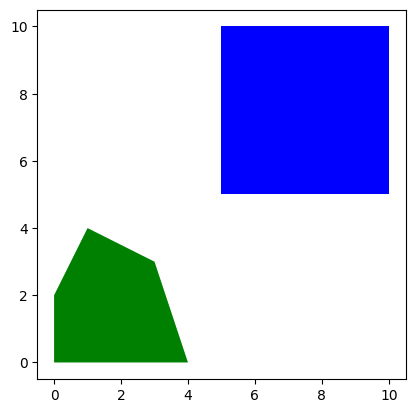

In [9]:
# Create two polygons
polygon1 = shapely.geometry.Polygon([(5, 5), (10, 5), (10, 10), (5, 10)])
polygon2 = shapely.geometry.Polygon([(0, 0), (4, 0), (3, 3), (1,4), (0, 2)])

polygon3= shapely.geometry.Polygon([(0, 8), (0, 11), (11, 11), (10, 0)])
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': [polygon1,polygon2]}, crs="EPSG:4326")

# Plot the GeoDataFrame
gdf.plot(color=["blue", "green", 'yellow'])
plt.show()


In [7]:
gdf.sindex.query(polygon3)

array([1, 0])

In [16]:
intersec_geom = gdf.intersection(polygon3)

In [17]:
valid_gdf = intersec_geom[~intersec_geom.is_empty]
num_boxes4img = [len(valid_gdf)]

<Axes: >

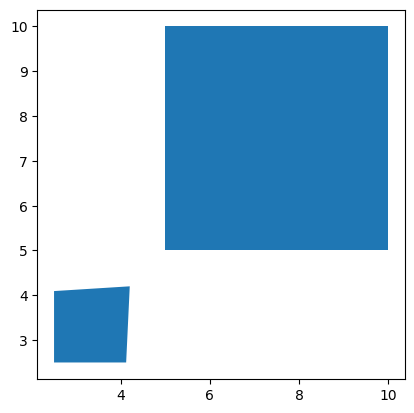

In [20]:
valid_gdf.plot()

In [18]:
if len(valid_gdf) > 0:
    boxes = samplers_utils.rel_bbox_coords(geodf = valid_gdf,
                                            ref_coords = polygon3.bounds,
                                            res = 1,
                                            ext_mt = 0)
else:
    boxes = np.empty((0,4))

In [19]:
boxes

[[2.5, 1.0, 7.5, 6.0], [0.0, 6.8, 1.7000000000000002, 8.5]]

In [34]:
hits = gdf.sindex.query(polygon3)

In [35]:
gdf.iloc[hits]

,geometry
1,"POLYGON ((0.00000 0.00000, 4.00000 0.00000, 2...."
0,"POLYGON ((5.00000 5.00000, 10.00000 5.00000, 1..."


In [7]:
import argparse

# Create the parser and add arguments
parser = argparse.ArgumentParser(description='Segment Maxar Tiles')
parser.add_argument('--batch-size', type=int, help='Batch size for processing')
parser.add_argument('--device', type=str, help='Device to use for computation')

# Define the arguments list as you would pass them in the command line
args_list = ['--batch-size', '32', '--device', 'cuda']

# Parse the arguments from the list
args = parser.parse_args(args_list)

# Now args contains the arguments
print(args.batch_size)  # Output: 32
print(args.device)      # Output: 'cuda'

32
cuda


In [8]:
for arg in vars(args):
    print(f"{arg}: {getattr(args, arg)}")


batch_size: 32
device: cuda


In [4]:
import argparse
parser = argparse.ArgumentParser(description='Segment Maxar Tiles')
args = parser.parse_args()

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: --f=/nfs/home/vaschetti/.local/share/jupyter/runtime/kernel-v2-1775473AqqbHxL4H1Ol.json


SystemExit: 2

/nfs/home/vaschetti/maxarSrc/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import numpy as np
import time

# Create large arrays for testing
canvas = np.random.rand(2, 1700, 1700)  # 2 rows, 1 million columns each
weights = np.random.rand(1700, 1700)    # 1 million elements

In [19]:
# Method 1: Process each index separately
start_time = time.time()
canvas_0 = np.divide(canvas[0], weights, out=np.zeros_like(canvas[0]), where=weights!=0)
canvas_1 = np.divide(canvas[1], weights, out=np.zeros_like(canvas[1]), where=weights!=0)
canvas_separate = np.stack((canvas_0, canvas_1), axis = 0)
end_time = time.time()
time_individual = end_time - start_time
print("Time taken by individual processing: {:.6f} seconds".format(time_individual))

Time taken by individual processing: 0.601446 seconds


In [20]:
# Method 2: Vectorized approach
start_time = time.time()
canvas_optimized = np.divide(canvas, weights, out=np.zeros_like(canvas), where=weights!=0)
end_time = time.time()
time_vectorized = end_time - start_time
print("Time taken by vectorized processing: {:.6f} seconds".format(time_vectorized))

Time taken by vectorized processing: 1.761179 seconds


In [21]:
# Check if the results are the same
print("Results are the same:", np.array_equal(canvas_optimized, canvas_separate))

Results are the same: True


In [1]:
import glob
import rasterio
from pathlib import Path
import os
import reverse_geocoder as rg
import pyproj
import geopandas as gpd
import sys

In [2]:
if Path.cwd().name != 'src':
    os.chdir('./src')
from maxarseg import build

In [5]:
from maxarseg.assemble import names
names.get_all_events()

['BayofBengal-Cyclone-Mocha-May-23',
 'Emilia-Romagna-Italy-flooding-may23',
 'Gambia-flooding-8-11-2022',
 'Hurricane-Fiona-9-19-2022',
 'Hurricane-Ian-9-26-2022',
 'Hurricane-Idalia-Florida-Aug23',
 'India-Floods-Oct-2023',
 'Indonesia-Earthquake22',
 'Kahramanmaras-turkey-earthquake-23',
 'Kalehe-DRC-Flooding-5-8-23',
 'Libya-Floods-Sept-2023',
 'Marshall-Fire-21-Update',
 'Maui-Hawaii-fires-Aug-23',
 'Morocco-Earthquake-Sept-2023',
 'NWT-Canada-Aug-23',
 'New-Zealand-Flooding23',
 'Sudan-flooding-8-22-2022',
 'afghanistan-earthquake22',
 'cyclone-emnati22',
 'kentucky-flooding-7-29-2022',
 'pakistan-flooding22',
 'shovi-georgia-landslide-8Aug23',
 'southafrica-flooding22',
 'tonga-volcano21',
 'yellowstone-flooding22']

In [4]:
bs = 2
config = build.SegmentConfig(batch_size = bs, device='cuda')

/home/vaschetti/.pyenv/versions/3.10.13/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
- GD model device: cuda:0
- Efficient SAM device: cuda:0


In [5]:
evento = build.Event(events_names[7], seg_config = config, when='pre')
print(evento.region_name)
all_mosaics_names = evento.all_mosaics_names
print(all_mosaics_names)
m0 = evento.mosaics[all_mosaics_names[0]]
print(f'Number of tiles: {m0.tiles_num}')

AfricaWest-Full
['10300100CFC9A500', '105001002BD68F00', '1040010073D77D00']
Number of tiles: 18


In [6]:
m0.set_build_gdf()

Found 3 links matching: [33303200, 333032, 3330320]


In [7]:
m0.proj_road_gdf

In [8]:
m0.tiles_paths[0]

PosixPath('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031231.tif')

In [9]:
m0.set_road_gdf()

not USA:  AfricaWest-Full.tsv


In [14]:
road_mask = m0.get_tile_road_mask_np(m0.tiles_paths[0])

array([0, 1], dtype=uint8)

In [16]:
import rasterio
from rasterio.windows import Window
from maxarseg import geoDatasets
from maxarseg import samplers
from maxarseg import segment
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from maxarseg import samplers_utils
import torch
from time import time

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [17]:
def segment_tile(self, tile_path):
    seg_config = self.event.seg_config

    dataset = geoDatasets.Maxar(str(tile_path))
    sampler = samplers.MyBatchGridGeoSampler(dataset, batch_size=seg_config.batch_size, size=seg_config.size, stride=seg_config.stride)
    dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

    canvas = np.zeros((seg_config.size, seg_config.size, 3), dtype=np.uint8)

    i = 0
    start_time_all = time()
    for batch in tqdm(dataloader):
        if i == 5:
            break
        if i != 4:
            i+=1
            continue
        original_img_tsr = batch['image']
        img_b = batch['image'].permute(0,2,3,1).numpy().astype('uint8') #TODO: l'immagine viene convertita in numpy ma magari è meglio lasciarla in tensor

        #trees
        GD_t_0 = time()
        tree_boxes_b, num_trees4img = segment.get_GD_boxes(img_b, seg_config.GD_model,
                                            seg_config.TEXT_PROMPT,
                                            seg_config.BOX_TRESHOLD,
                                            seg_config.TEXT_TRESHOLD,
                                            dataset.res,
                                            device = seg_config.device,
                                            max_area_mt2 = seg_config.max_area_GD_boxes_mt2)
        print('GD_time: ', time() - GD_t_0)
        print('- GD model device:', next(seg_config.GD_model.parameters()).device)
        
        #building            
        print(batch['bbox'])            
        building_boxes_b, num_build4img = segment.get_batch_buildings_boxes(batch['bbox'],
                                                                    proj_buildings_gdf = self.proj_build_gdf,
                                                                    dataset_res = dataset.res,
                                                                    ext_mt = 10)
        max_detect = max(num_trees4img + num_build4img)
        print(f'max_detect: {max_detect}')
        input_points, input_labels = build.get_input_pts_and_lbs(tree_boxes_b, building_boxes_b, max_detect)
        
        #boxes4FSam = build.get_boxes4FSam(tree_boxes_b, building_boxes_b, max_detect)
        #print('tree_b shape: ', building_boxes_b[0].shape)
        #print('input_points shape: ', input_points.shape)
        #print('input_labels shape: ', input_labels.shape)

        all_masks_b = segment.ESAM_from_inputs(original_img_tsr,
                                                torch.from_numpy(input_points),
                                                torch.from_numpy(input_labels),
                                                efficient_sam = seg_config.efficient_sam,
                                                device = seg_config.device,
                                                num_parall_queries = 17)
        
        tree_mask_b, building_mask_b, pad_mask_b = segment.discern(all_masks_b, num_trees4img, num_build4img)

        #roads
        """get_road_masks_b(batch['bbox'],
                         self.proj_road_gdf,
                         seg_config.size,
                         dataset.res,
                         ext_mt = 10)"""
        
        #road_mask_b = segment.get_road_mask(img_b,)
        i += 1
    print(f'\nTotal Time for {seg_config.batch_size * i} images: ', time() - start_time_all)
    return img_b, original_img_tsr#, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b

_, _ = segment_tile(m0, m0.tiles_paths[17])
#img_b, original_img, tree_boxes_b, building_boxes_b, all_masks_b, tree_mask_b, building_mask_b, pad_mask_b = segment_tile(m0, m0.tiles_paths[17])

  0%|          | 0/1682 [00:00<?, ?it/s]

  0%|          | 2/1682 [00:00<01:35, 17.58it/s]

In sampler
tile_polygon:  POLYGON ((315427.24609375 1485156.25, 320156.25 1485156.25, 320156.25 1479843.75, 315394.8974609375 1479843.75, 315427.24609375 1485156.25))


  0%|          | 4/1682 [00:04<33:06,  1.18s/it]

GD_time:  4.442540645599365
- GD model device: cuda:0
[BoundingBox(minx=316033.935546875, maxx=316217.041015625, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18), BoundingBox(minx=316125.48828125, maxx=316308.59375, miny=1479843.75, maxy=1480026.85546875, mint=0.0, maxt=9.223372036854776e+18)]
max_detect: 83
-1


ValueError: index can't contain negative values

In [ ]:
m0.segment_tile()